<a href="https://colab.research.google.com/github/LucasJFaust/data-science-cases/blob/main/Case_clustering_crisp_dm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Business Understanding

Um e-commerce do Reino Unido contratou os alunos da DNC para agruparem seus clientes com base nas métricas RFM (discutidas abaixo), para então definir estratégias de fidelização.

RFM:
- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do **ticket médio** gasto pelo cliente


O conjunto de dados fornecido contém transações ocorridas entre dezembro de 2010 e dezembro de 2011.

Seu objetivo é clusterizar os clientes com base em suas métricas de RFM.

Fonte do dataset [neste link](https://www.kaggle.com/datasets/carrie1/ecommerce-data).

# Step 2 : Data Understanding

## Setup

In [1]:
%%capture
%pip install sidetable

In [2]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

In [3]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

## Dataset

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/cmcouto-silva/datasets/main/datasets/e-commerce.csv', encoding='latin1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data understanding

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.InvoiceNo.sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

In [7]:
df[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

<Axes: >

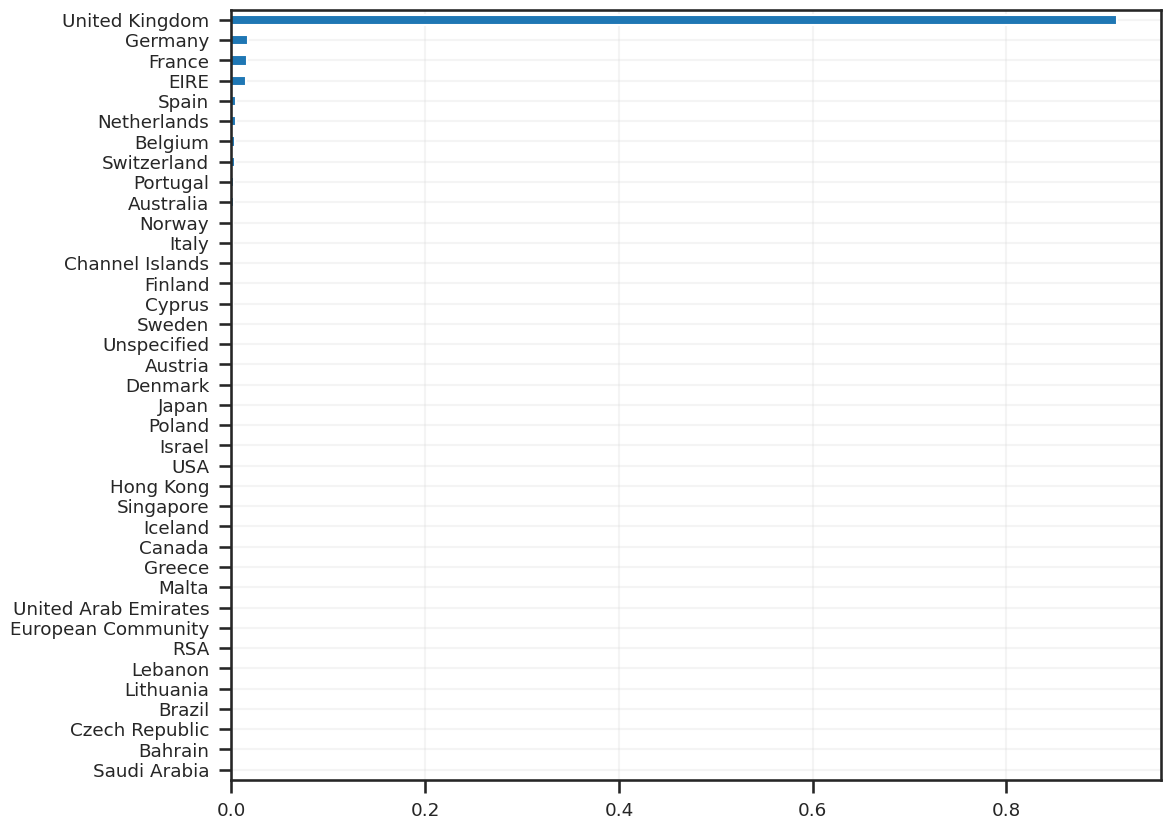

In [8]:
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

In [9]:
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [10]:
df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [12]:
df.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [13]:
df.duplicated().sum()

5268

In [14]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Step 3 : Data Preparation

## Data Cleaning

In [15]:
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


In [16]:
df = df.dropna(subset=['CustomerID'])

In [17]:
df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


In [18]:
%%timeit
pd.to_datetime(df.InvoiceDate)

2 s ± 369 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

126 ms ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

<ipython-input-20-0a4a47e6cb3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')


In [21]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

<ipython-input-21-8861d7906295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)
<ipython-input-21-8861d7906295>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'] = df['Country'].astype('category')


In [22]:
df = df.copy()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.2+ MB


In [24]:
df.InvoiceDate.agg(['min','max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

In [25]:
below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

<Axes: >

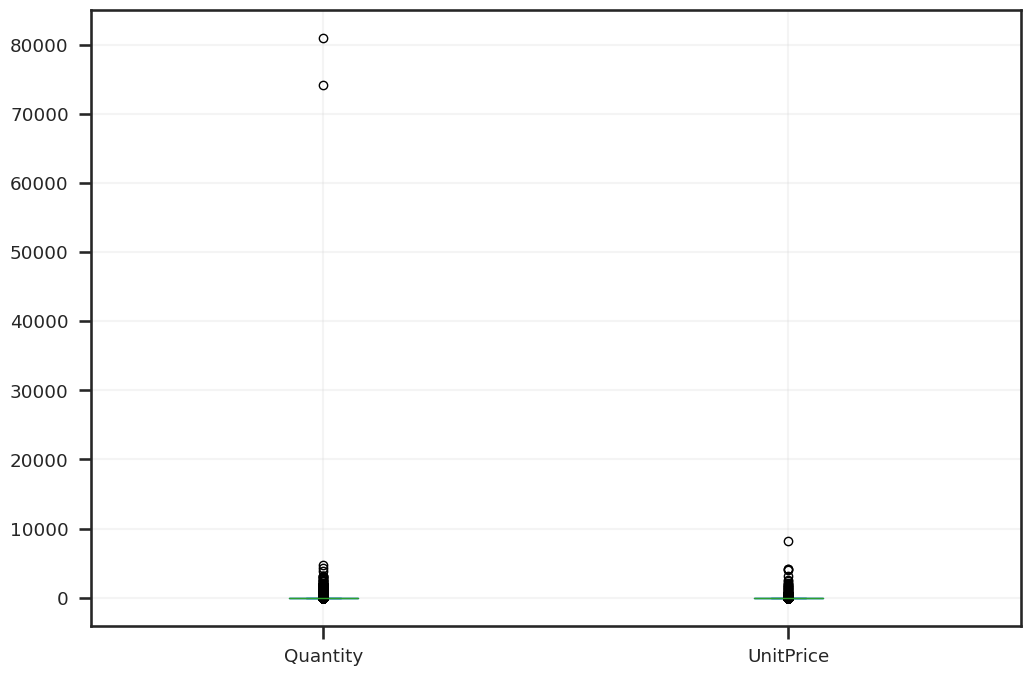

In [26]:
df[['Quantity','UnitPrice']].plot.box()

In [27]:
df.query('Quantity>10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


<Axes: >

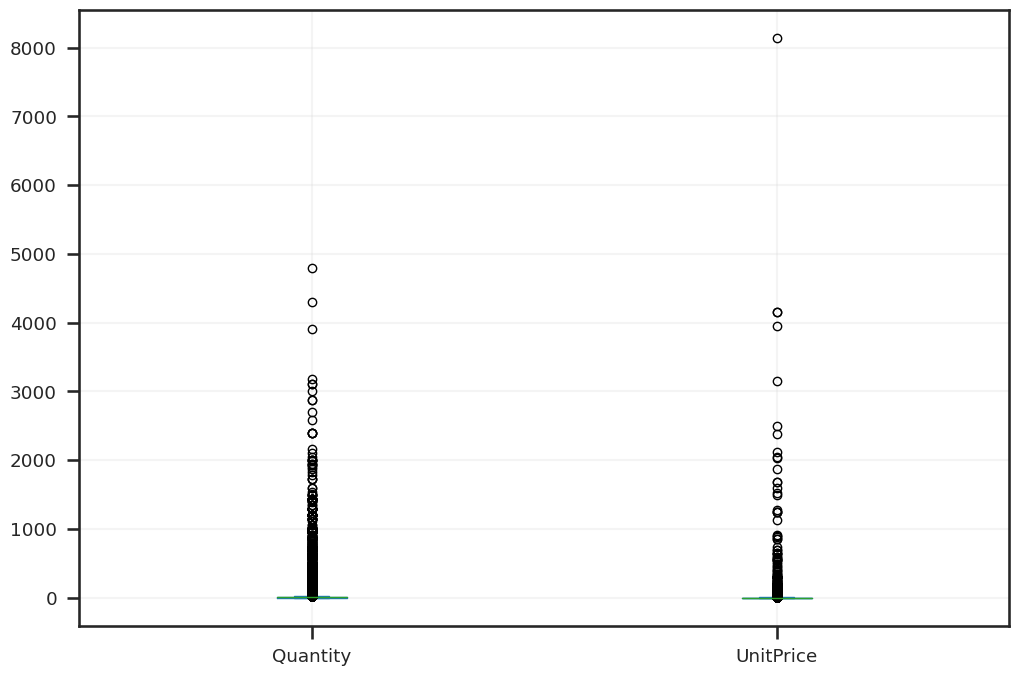

In [28]:
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

In [29]:
df.query('UnitPrice>8_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


In [30]:
df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

In [31]:
df['price_total'] = df.Quantity * df.UnitPrice
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


RFM

In [32]:
pd.Timestamp.today()

Timestamp('2024-03-28 17:22:26.432874')

In [33]:
pd.Timestamp('2012-01-01')

Timestamp('2012-01-01 00:00:00')

In [34]:
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('price_total', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


<Axes: >

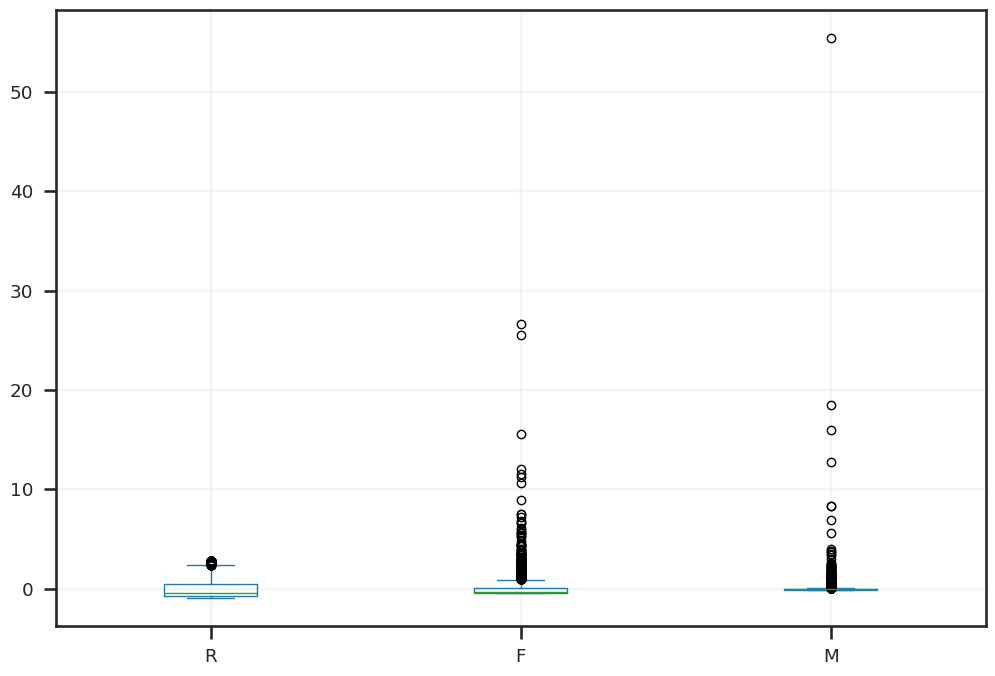

In [35]:
df_rfm.apply(scale).plot.box()

In [36]:
df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098,0.899878,-0.165317,55.434876


In [37]:
df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


In [38]:
df_rfm = df_rfm.drop(15098)

<Axes: >

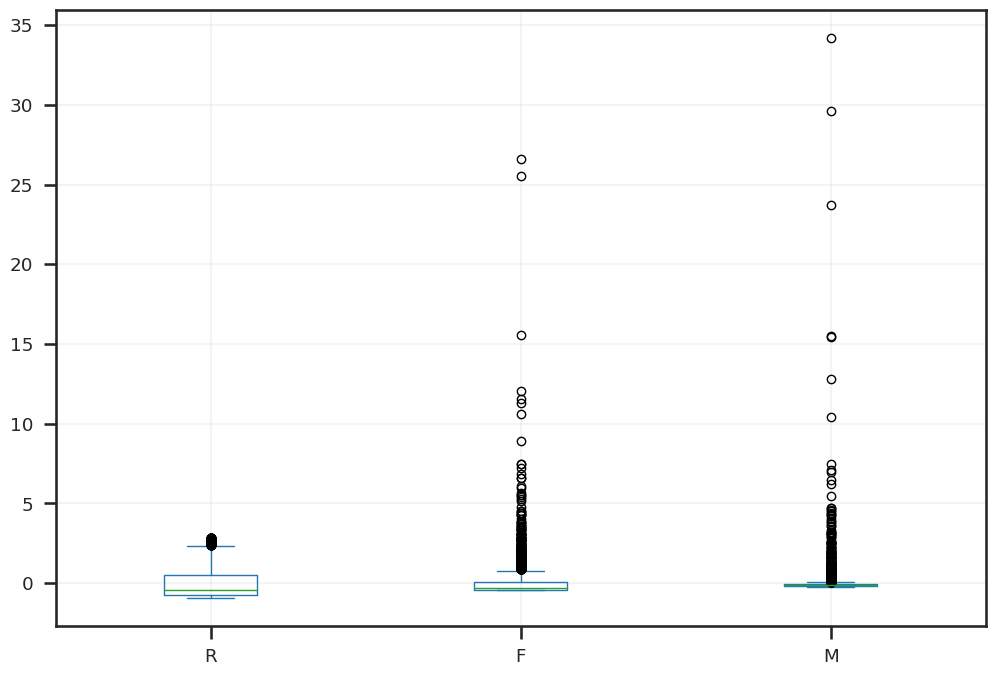

In [39]:
df_rfm.apply(scale).plot.box()

In [40]:
from sklearn.preprocessing import PowerTransformer

In [41]:
scaler = PowerTransformer()

In [42]:
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.563219,1.201866,0.407836
12348,0.323470,0.660670,1.329304
12349,-0.809134,-1.158070,0.426829
12350,1.568467,-1.158070,0.189376
12352,-0.307718,1.309671,0.653411
...,...,...,...
18280,1.475652,-1.158070,0.085562
18281,1.107356,-1.158070,-0.491003
18282,-1.275046,-0.195707,-0.161007


<Axes: >

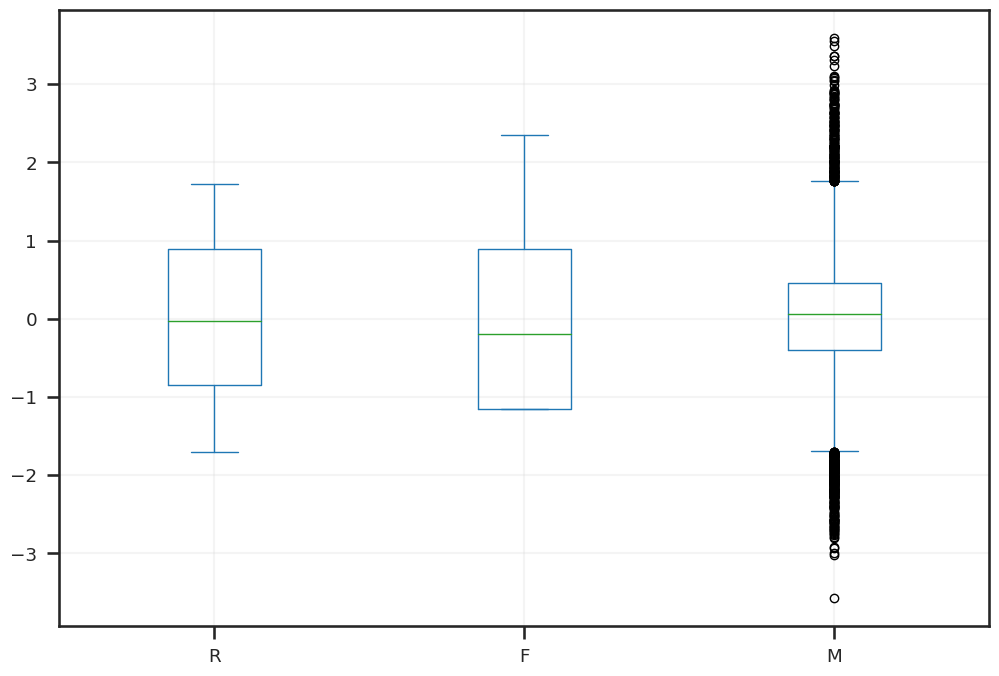

In [43]:
df_rfm_scaled.plot.box()

In [44]:
scaler.inverse_transform(df_rfm_scaled)

array([[24.        ,  7.        , 23.68131868],
       [97.        ,  4.        , 57.97548387],
       [40.        ,  1.        , 24.0760274 ],
       ...,
       [29.        ,  2.        , 14.8375    ],
       [25.        , 16.        ,  2.77100529],
       [64.        ,  3.        , 26.24685714]])

In [45]:
df_rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.554185
std,99.968352,7.697927,129.202663
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,395.000000,209.000000,4453.430000


In [46]:
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.634656
std,95.504576,3.358999,20.993635
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,333.000000,13.000000,91.768421


In [47]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)

# Step 4-5: Modeling & Model evaluation

## K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

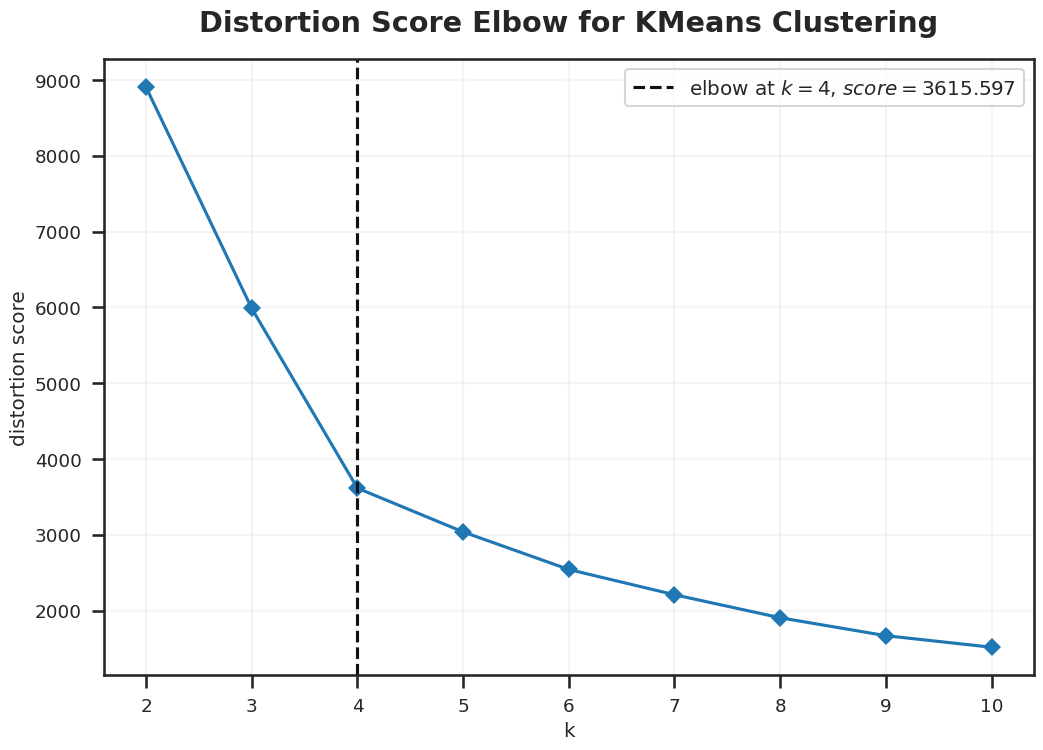

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [48]:
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

In [49]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8906.589803,0.382311,1.065369,1995.770793
3,5987.858046,0.434196,0.858749,2539.996344
4,3615.604890,0.479553,0.704462,3751.144746
5,3038.351886,0.484991,0.737341,3552.793389
6,2542.498169,0.398087,0.851009,3564.654984
7,2209.186985,0.376864,0.870175,3526.795460
8,1907.066277,0.383598,0.862066,3599.016667
9,1668.785587,0.394119,0.800873,3675.190014
10,1516.641890,0.351595,0.887744,3641.963320


In [50]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [51]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

## Hierarchical Clustering

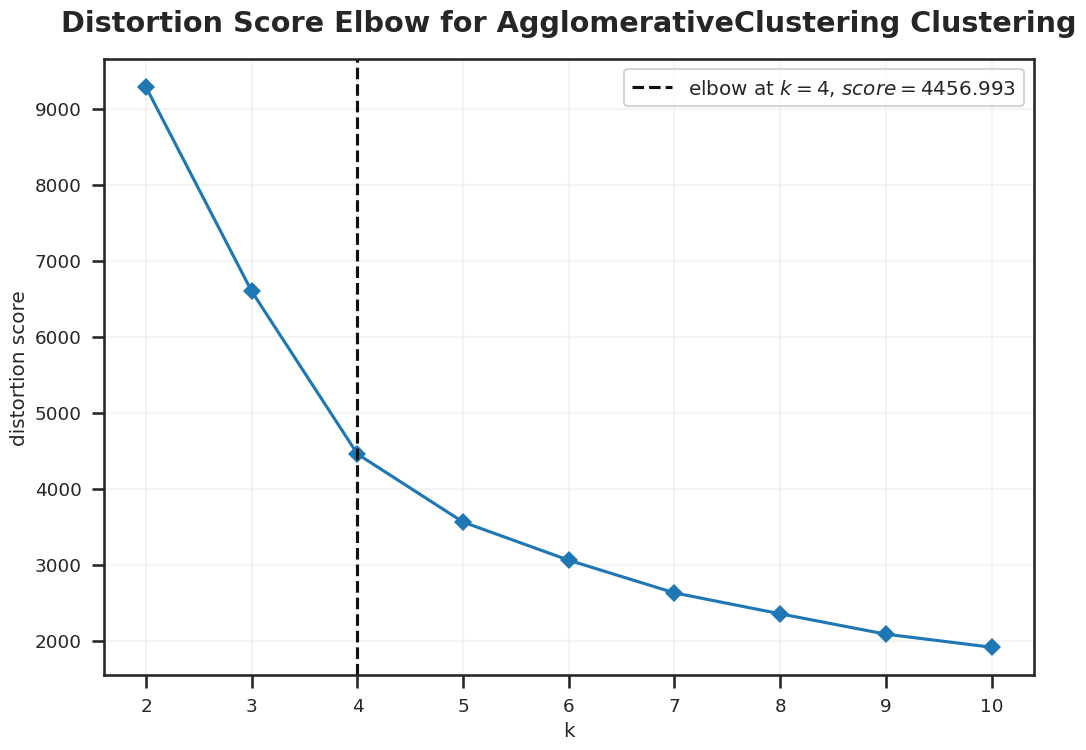

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [52]:
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [53]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.361292,1.331666,1737.623791
3,0.398928,0.869855,2104.783905
4,0.431886,0.761966,2770.399918
5,0.342136,0.897329,2872.239315
6,0.348298,0.791909,2816.854970
7,0.322680,0.844326,2848.491623
8,0.287643,0.967432,2799.001327
9,0.286883,0.976982,2832.797336
10,0.298923,0.953087,2786.657350


In [54]:
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [55]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

## Gaussian Mixture

In [56]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = df_rfm_clip_scaled.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
28,-690.837272,8,full
30,60.344702,8,diag
24,205.109991,7,full
26,211.212551,7,diag
20,9370.785790,6,full


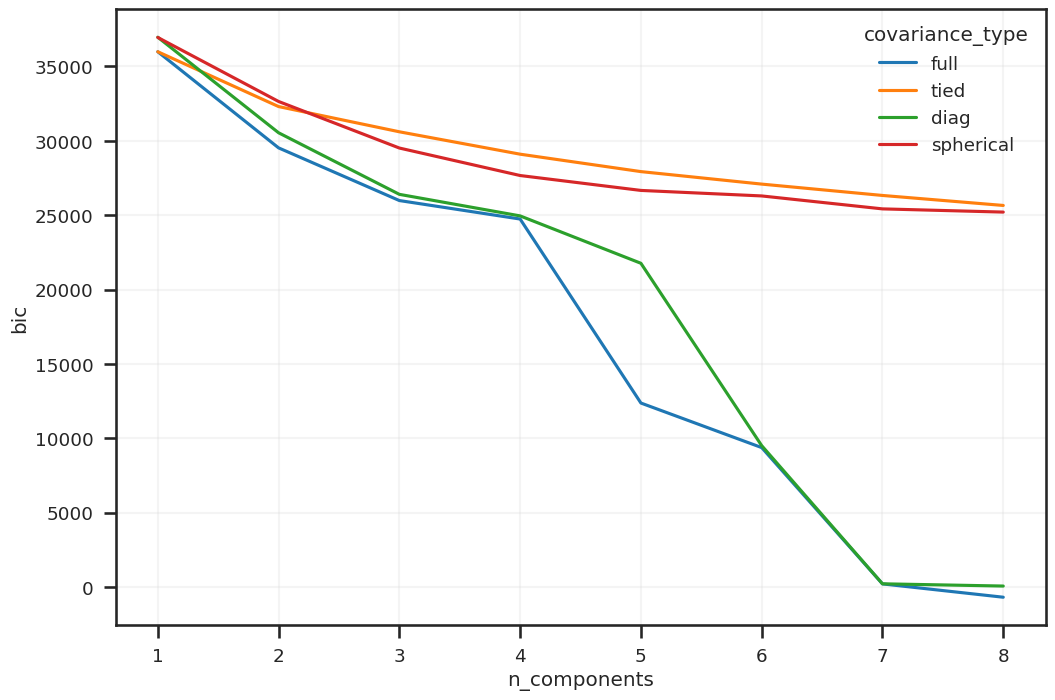

In [57]:
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');

In [58]:
mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_rfm_clip_scaled)

In [59]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

# Step 5: Interpretação dos clusters

In [60]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

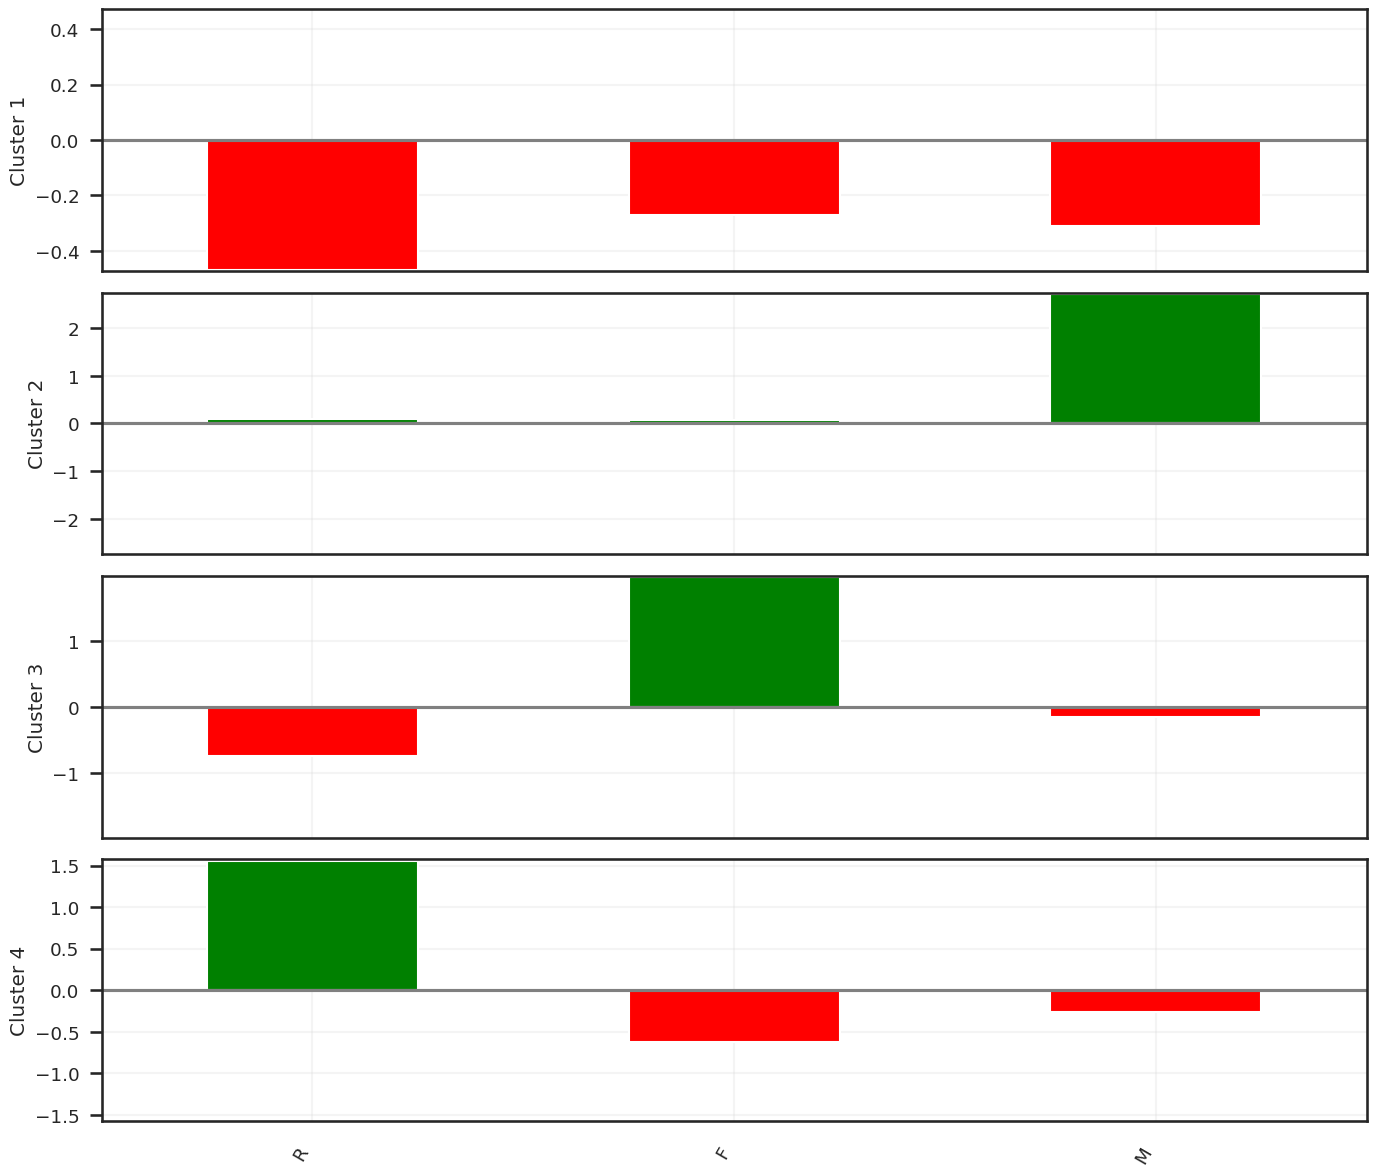

In [61]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [62]:
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,67.523221,121.057935,41.517018,261.082051
F,2.703877,3.876574,10.191248,1.509744
M,17.120301,80.714098,20.426973,18.104189
